In [3]:
import numpy as np
import pandas as pd
import plotly.express as px
import os
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

In [4]:
# font sizes
titleSize = 32
axisLabelSize = 26
tickLabelSize = 16
legendTextSize = 16

# colours
backgroundColor = '#292929'
legendColor = 'w'

# misc
standardCanvasHeight = 8
standardCanvasWidth = 16
DPI = 300 #Dots per inch of plots 

In [5]:
earthRadius = 6371146 # in m
def getProm(h_dist):
    return h_dist*h_dist/2/earthRadius

summits = pd.read_csv(f'summits_result.txt', sep=",", index_col=0, header=None)
summits.columns = ["latitude", "longitude", "elevation", "h_distance"]
summits["prominence"] = summits.h_distance.apply(getProm).round(1)

minPrm = summits.prominence.min()

numSummits = len(summits)
print(f'Number of Points (> 30 m): {numSummits}')

summits300 = summits.query('prominence > @minPrm*10')
numSummits300 = len(summits300)
print(f'Number of Points (> 300 m): {numSummits300} ({round(numSummits300/numSummits, 2)} of points)')
summits3000 = summits.query('prominence > @minPrm*100')
numSummits3000 = len(summits3000)
print(f'Number of Points (> 3000 m): {numSummits3000} ({round(numSummits3000/numSummits, 4)} of points)')

Number of Points (> 30 m): 10549
Number of Points (> 300 m): 1489 (0.14 of points)
Number of Points (> 3000 m): 60 (0.0057 of points)


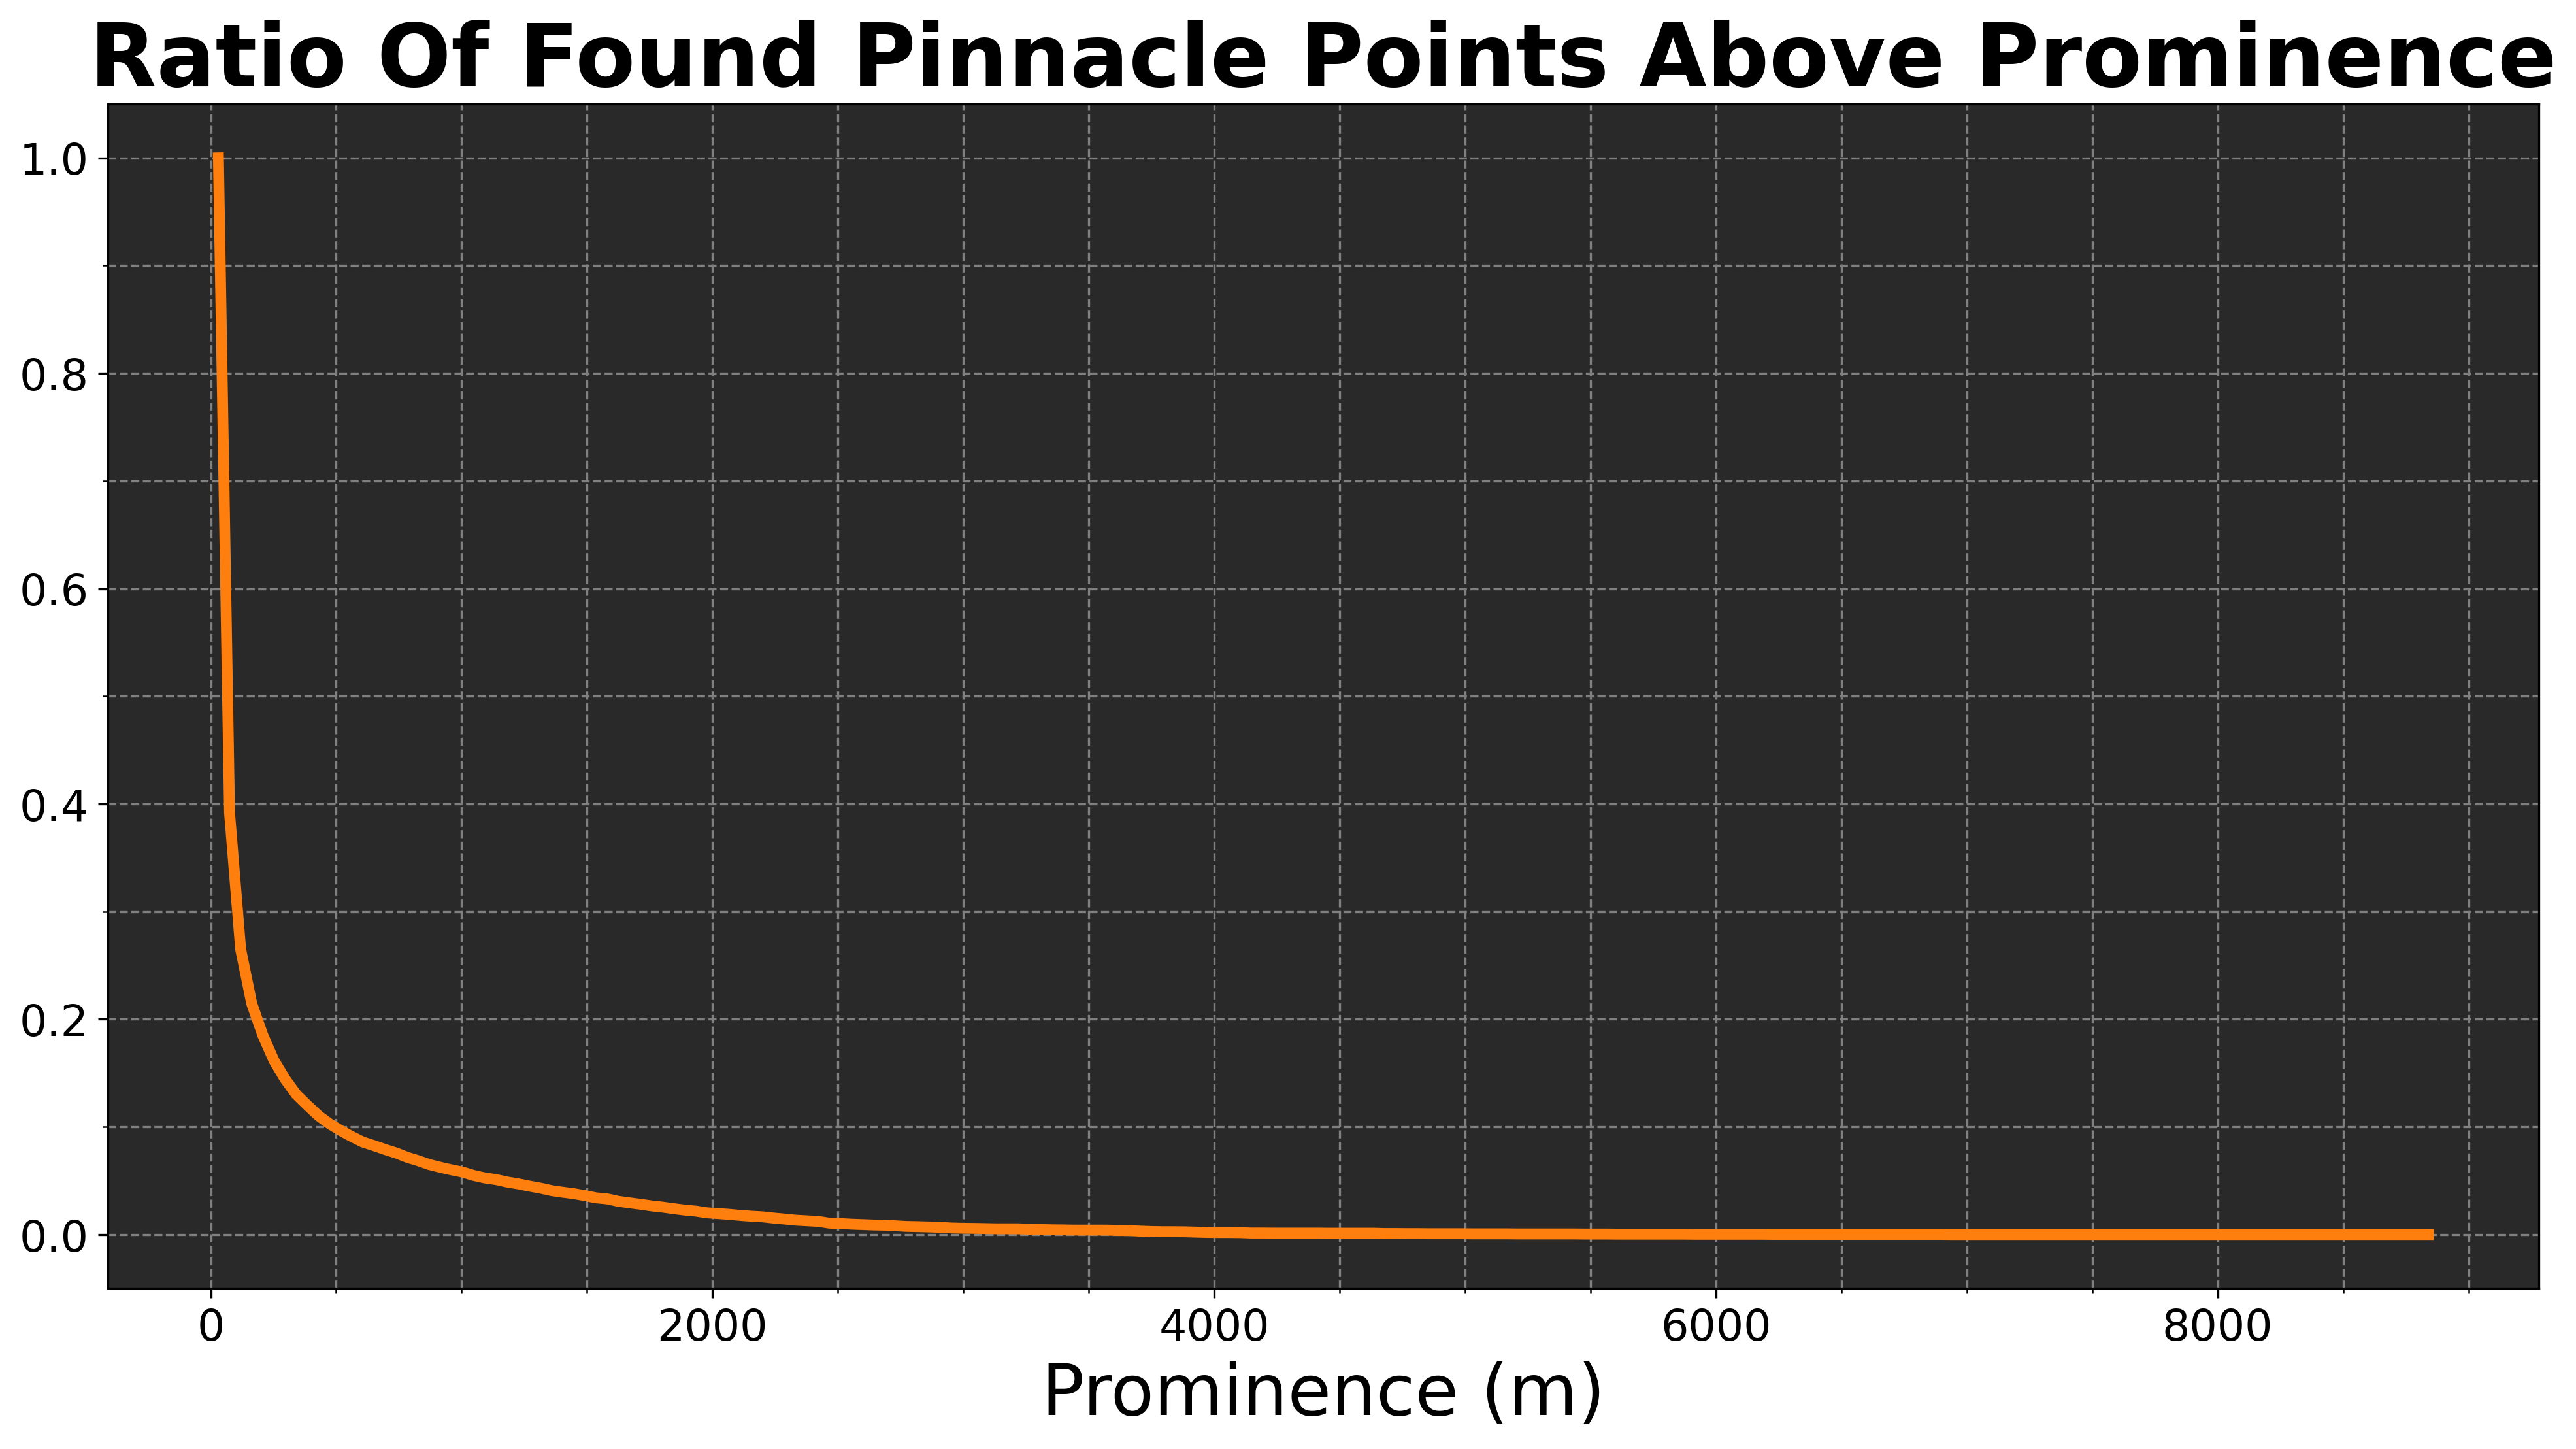

In [20]:
def percentAboveProminence(dataframe, prm):
    numberAboveProminence = len(dataframe.query(f'prominence >= {prm}'))
    return numberAboveProminence/len(dataframe)

prominenceRange =np.linspace(summits.prominence.min(), summits.prominence.max(), 200)
percentAbove = [percentAboveProminence(summits, prm) for prm in prominenceRange]

fig = plt.gcf()
ax = plt.gca()
title = "Ratio Of Found Pinnacle Points Above Prominence"
ax.set_title(title, size=titleSize, fontweight='bold')
plt.xlabel("Prominence (m)", size=axisLabelSize)

plt.rcParams['axes.facecolor'] = backgroundColor
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
fig.set_dpi(DPI)
plt.grid(axis="both", which="both", ls='--', c='grey')
ax.tick_params(axis='both', which='both', labelsize=tickLabelSize)
ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.grid(True, which='minor')
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
fig.patch.set_facecolor('w')

plt.plot(prominenceRange, percentAbove, c='tab:orange', lw=4)
plt.savefig(f'{title.replace(" ", "")}')
plt.show()

In [9]:
def findClosestPoints(lat, lng, dataframe, N=5):
    lat_rad, lng_rad = np.radians(lat), np.radians(lng)

    dlat = np.radians(dataframe['latitude']) - lat_rad
    dlng = np.radians(dataframe['longitude']) - lng_rad

    # Apply Haversine formula to calculate distances
    a = np.sin(dlat/2)**2 + np.cos(lat_rad)*np.cos(np.radians(dataframe['latitude']))*np.sin(dlng/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distances = earthRadius/1000 * c
    
    distances = distances.sort_values().round(1)
    
    closestDistances = distances.head(N)
    
    # Return the closest row
    closest_row = dataframe.loc[closestDistances.index]
    closest_row['distance'] = closestDistances
        
    return closest_row

findClosestPoints(51.4874, -101.9027, summits300, 5)

,latitude,longitude,elevation,h_distance,prominence,distance
0,,,,,,
95315,51.4700,-100.7206,833.9,70702.2,392.3,81.9
113325,52.7156,-101.4547,823.9,68094.9,363.9,140.0
130746,53.4233,-102.2908,825.7,66014.1,342.0,216.9
68297,57.6678,-105.2761,879.3,75765.4,450.5,720.6
162728,54.9158,-111.3406,865.0,62849.9,310.0,734.3


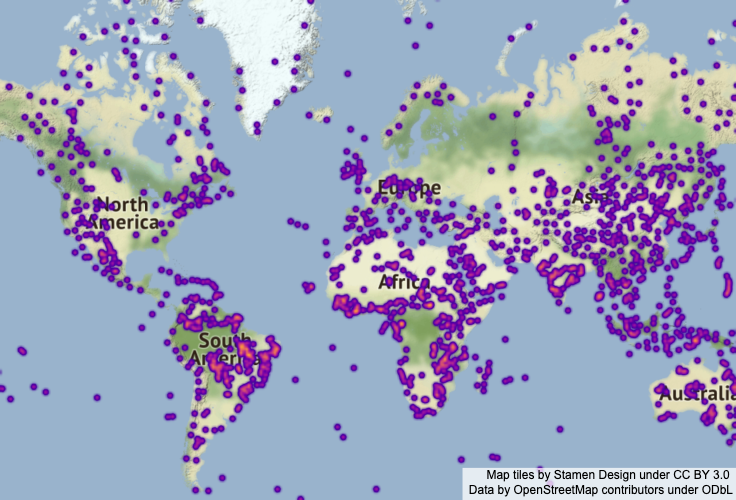

In [11]:
fig = px.density_mapbox(summits300,
                        lat="latitude",
                        lon="longitude",
                        radius=5,
                        center=dict(lat=30, lon=0),
                        zoom=0.8,
                        width=1000,
                        height=500,
                        mapbox_style="stamen-terrain")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update(layout_coloraxis_showscale=False)
fig.show()